# Dataset

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from step_2.datasets import COCOSegmentation

In [3]:
dataDir='../Datasets/coco-2017/'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [4]:
dataset = COCOSegmentation(dataDir, 'val', crop_size=0)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=None)

val set
loading annotations into memory...
Done (t=0.81s)
creating index...
index created!


In [5]:
i, l, n = dataset[0]
i.shape, l.shape, n

((427, 640, 3), torch.Size([427, 640]), '397133')

In [6]:
for (i, l, n) in dataloader:
    print(i.shape, l.shape, n)
    break

torch.Size([1, 427, 640, 3]) torch.Size([1, 427, 640]) ['397133']


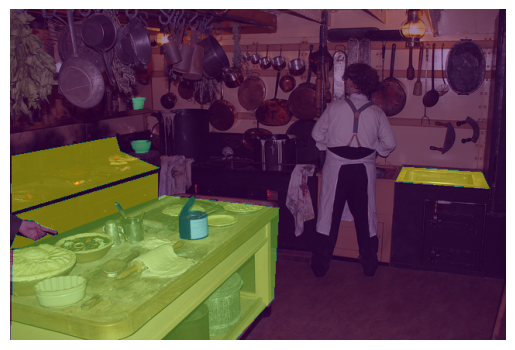

tensor([ 0,  1, 44, 49, 51, 67, 79, 81])

In [7]:
plt.imshow(i[0])
plt.imshow(l[0], alpha=0.5)
plt.axis('off')
plt.show()
l.unique()

# Model

In [13]:
import requests

import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import torch
from mobile_sam import sam_model_registry, SamPredictor

from step_2.utils import *

### Load model

In [10]:
torch.manual_seed(0)
np.random.seed(0)

GPU = 3

device = torch.device(f"cuda:{GPU}" if torch.cuda.is_available() else "cpu")

In [11]:
model_type = "vit_t"
sam_checkpoint = "bin/mobile_sam.pt"

model = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device).eval()
predictor = SamPredictor(model)

### Get Input Image

In [14]:
img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
raw_image = np.array(Image.open(requests.get(img_url, stream=True).raw).convert("RGB"))
# plt.imshow(raw_image)
# plt.show()

In [15]:
raw_image.shape

(1764, 2646, 3)

### Run Inference with Prompt

In [16]:
input_points = np.array([[450, 600]])
input_label = np.array([1])

In [18]:
input_points = np.array([[450, 600]])
input_label = np.array([1])



with torch.no_grad():
    predictor.set_image(raw_image)
    masks, scores, _ = predictor.predict(input_points, input_label)

In [19]:
scores

array([1.0082304 , 0.9789133 , 0.91200805], dtype=float32)

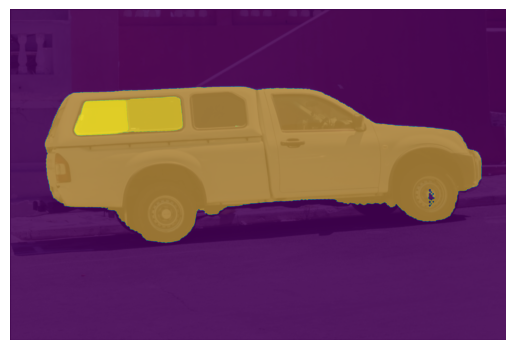

In [20]:
plt.imshow(raw_image)
plt.imshow(masks[0], alpha=0.5)
plt.imshow(masks[1], alpha=0.5)
plt.imshow(masks[2], alpha=0.5)
plt.axis('off')
plt.show()

### Decode Output

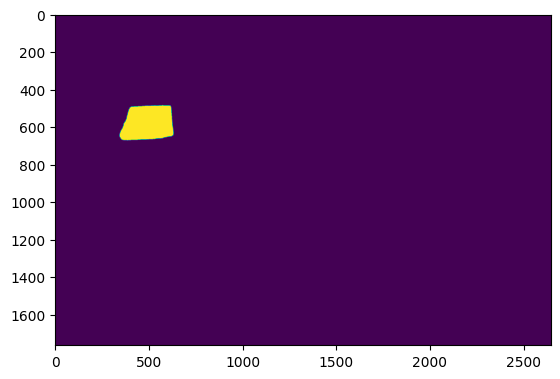

In [21]:
plt.imshow(masks[np.argmax(scores)])
plt.show()

# Outputs

In [22]:
import random
import torch

In [23]:
CENTER = True

In [43]:
def get_output_masks(processor, model, i, input_points, device):
    i = i[0].detach().cpu().numpy().astype(np.uint8)
    predictor.set_image(i)
    masks, scores, _ = predictor.predict(np.array(input_points[0]), np.array([1]))
    return masks, scores
    
def get_prompt(name, label):

    # Load_prompts missing

    C = np.unique(label)[1:]
    c = np.random.choice(C)

    if CENTER:
        x, y = torch.sum(torch.argwhere(label==c),0)/torch.sum(label==c).detach().cpu().numpy()
        x, y = int(x), int(y)
    else:
        x_v, y_v = np.where(label == c)
        r = random.randint(0,len(x_v))
        x, y = x_v[r], y_v[r]
    return [[[y,x]]], c # inverted to compensate different indexing

In [44]:
def get_masks():

    name_list, mask_list, score_list, prompt_list, p_class_list = [], [], [], [], []
    for j, (i, l, n) in enumerate(dataloader):

        prompt, p_class = get_prompt(n, l[0])
        # show_points_on_image(i[0], input_points[0])

        masks, scores = get_output_masks(None, predictor, i, prompt, device)
        # show_masks_on_image(i[0], masks, scores)  
        name_list.append(int(n[0]))
        mask_list.append(masks.squeeze()[scores.argmax()])
        score_list.append(float(scores.max()))
        prompt_list.append(prompt[0][0])
        p_class_list.append(int(p_class))

        if j > 1:
            break

    return name_list, prompt_list, p_class_list, mask_list, score_list

In [45]:
name, prompt, p_class, mask, score = get_masks()

(427, 640, 3)
397133
(427, 640)
0.9315961599349976
[167, 155]
51
(230, 352, 3)
37777
(230, 352)
0.9921293258666992
[326, 152]
82
(428, 640, 3)
252219
(428, 640)
0.974840521812439
[611, 126]
28


In [53]:
i = 1
name[i], prompt[i], p_class[i], mask[i].shape, score[i]

(37777, [326, 152], 82, (230, 352), 0.9921293258666992)

refrigerator
37777


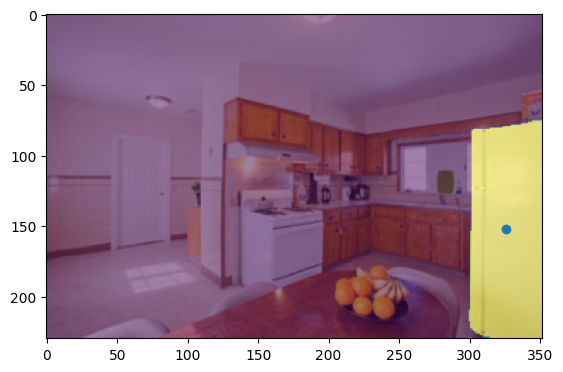

In [54]:
im = Image.open('../Datasets/coco-2017/val2017/' + str(name[i]).zfill(12) + '.jpg')
plt.imshow(im)
plt.imshow(mask[i], alpha=0.5)
print(dataset.classes[p_class[i]])
print(name[i])
plt.scatter(*prompt[i])
plt.show()

### Save DataFrame

In [55]:
import pandas as pd

In [56]:
df = pd.DataFrame({'name': name, 'prompt': prompt, 'class': p_class, 'mask': mask, 'score': score})

In [57]:
df.head()

,name,prompt,class,mask,score
0,397133,"[167, 155]",51,"[[False, False, False, False, False, False, Fa...",0.931596
1,37777,"[326, 152]",82,"[[False, False, False, False, False, False, Fa...",0.992129
2,252219,"[611, 126]",28,"[[False, False, False, False, False, False, Fa...",0.974841


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    3 non-null      int64  
 1   prompt  3 non-null      object 
 2   class   3 non-null      int64  
 3   mask    3 non-null      object 
 4   score   3 non-null      float64
dtypes: float64(1), int64(2), object(2)
memory usage: 248.0+ bytes


array([[<Axes: title={'center': 'class'}>]], dtype=object)

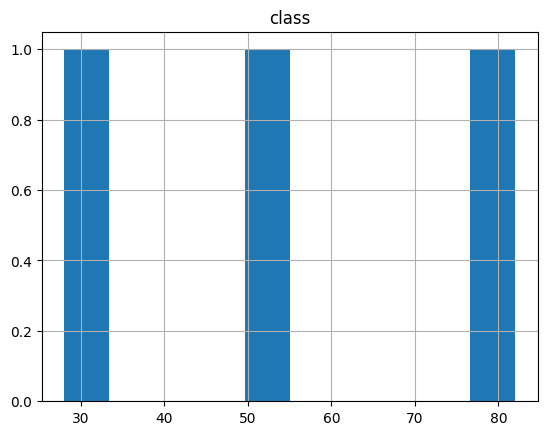

In [59]:
df.hist(column='class')

In [ ]:
df[['name', 'point', 'class']].to_pickle("results/coco_prompts.pkl")

In [ ]:
df[['name', 'point', 'class']]

In [ ]:
df = pd.read_pickle("results/cityscapes_prompts.pkl")

In [ ]:
df.head()

In [ ]:
df[df['name']==632][['point', 'class']].values[0][1]

### Predicted Classes

In [ ]:
N_CLASSES = 92

In [ ]:
def get_instance(label, c=None):
    if c is None:
        C = np.unique(label)[1:]
        c = np.random.choice(C)
        return label == c, c
    else:
        return label == c, c

def get_pred_classes(inst, label, n_classes, threshold=0.01):
    im = torch.logical_not(inst).to(torch.uint8)
    im[im==1] = n_classes
    m = im + label
    h, _ = np.histogram(m, bins=256, range=(0,255))
    clean_h = h[:n_classes]
    mask_tot = np.sum(clean_h)
    classes = np.where(clean_h > threshold * mask_tot)[0]
    return list(classes)

### Test class threshold

In [ ]:
# Label
l = torch.zeros((224,224), dtype=torch.uint8)
l[100:150, 50:100] = 35
l[145:150, 95:100] = 91
l[100:140, 160:200] = 60
l[100:115, 50:65] = 0

plt.imshow(l)
plt.show()

In [ ]:
# Predicted instance
i = torch.zeros((224,224), dtype=bool)
i[100:150, 50:100] = True
plt.imshow(i)
plt.show()

In [ ]:
get_pred_classes(i, l, N_CLASSES, 0.01)

In [ ]:
# Modified instance
im = torch.logical_not(i).to(torch.uint8)
im[im==1] = N_CLASSES

plt.imshow(im)
plt.show()

In [ ]:
im.min(), im.max()

In [ ]:
# Mask (intersection)
m = im + l

plt.imshow(m)
plt.show()

In [ ]:
m.unique()

In [ ]:
h, _ = np.histogram(m, bins=256, range=(0,255))
h

In [ ]:
clean_h = h[:N_CLASSES]
clean_h

In [ ]:
mask_tot = np.sum(clean_h)
mask_tot

In [ ]:
np.where(clean_h > 0.01 * mask_tot)

# Metrics

In [60]:
from pathlib import Path
import numpy as np
import pandas as pd
import PIL.Image as Image
import matplotlib.pyplot as plt

from step_2.utils import show_points_and_masks_on_image

%matplotlib inline
%load_ext autoreload

In [61]:
EXPERIMENT = ''
DATASET = 'coco'
MODEL = 'MobileSAM'
ROOT = Path("../Datasets/coco-2017/val2017/") if DATASET == 'coco' else Path("../Datasets/Cityscapes/leftImg8bit/val/")
SPARSITY = 50
CLASSES = ['background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
           'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 
           'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports', 'kite', 
           'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 
           'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
           'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
           'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
           'hair drier', 'toothbrush', 'hair brush']

In [62]:
def calculate_metrics(target, pred, eps=1e-5, verbose=False):

    if verbose:
        plt.subplot(1, 2, 1)
        plt.imshow(target)
        plt.subplot(1, 2, 2)
        plt.imshow(pred)
        plt.show()

    output = np.reshape(pred, -1)
    target = np.reshape(target, -1)

    tp = np.sum(output * target)  # TP (Intersection)
    un = np.sum(output + target)  # Union
    fp = np.sum(output * (~target))  # FP
    fn = np.sum((~output) * target)  # FN
    tn = np.sum((~output) * (~target))  # TN

    iou = (tp + eps) / (un + eps)
    pixel_acc = (tp + tn + eps) / (tp + tn + fp + fn + eps)
    dice = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    precision = (tp + eps) / (tp + fp + eps)
    recall = (tp + eps) / (tp + fn + eps)
    specificity = (tn + eps) / (tn + fp + eps)

    if verbose:
        print(f"IoU: {iou:.4f}, Pixel Acc: {pixel_acc:.4f}, Dice: {dice:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Specificity: {specificity:.4f}")

    return iou, pixel_acc, dice, precision, specificity, recall

def get_analytics(target_df, pred_df):
    metrics = {k: [] for k in ['name', 'prompt', 'class', 't_class', 's_class', 'score', 'score_diff', 'mask_size', 
                               'mask_size_diff', 'iou', 'pixel_acc', 'dice', 'precision', 'recall', 'specificity']}
    for i in range(len(target_df)):
        target = target_df.loc[i]
        pred = pred_df.loc[i]

        iou, pixel_acc, dice, precision, specificity, recall = calculate_metrics(target['mask'], pred['mask'])
        
        metrics['name'].append(target['name'])
        metrics['prompt'].append(target['prompt'])
        metrics['class'].append(target['class'])
        metrics['t_class'].append(target['s_class'])
        metrics['s_class'].append(pred['s_class'])
        metrics['score'].append(pred['score'])
        metrics['score_diff'].append((pred['score'] - target['score']) / (target['score'] + 1e-5))
        p_size = np.mean(pred['mask'].astype('float'))
        t_size = np.mean(target['mask'].astype('float'))
        metrics['mask_size'].append(p_size)
        metrics['mask_size_diff'].append((p_size - t_size) / (t_size + 1e-3))
        metrics['iou'].append(iou)
        metrics['pixel_acc'].append(pixel_acc)
        metrics['dice'].append(dice)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['specificity'].append(specificity)
    
    return pd.DataFrame(metrics)

def get_labels(name):
    if isinstance(name, list):
        return [get_labels(n) for n in name]
    else: 
        return CLASSES[name].title()

def get_image(name):
    if DATASET == 'coco':
        image_path = ROOT.joinpath(f'{str(name).zfill(12)}.jpg')
    else:
        image_path = ROOT.joinpath(f"{name.split('_')[0]}/{name}")
    return np.array(Image.open(image_path).convert("RGB"))

def show_entry(row, target_df, pred_df):
    image = get_image(row['name'])
    target_mask = target_df[target_df['name']==row['name']]['mask'].values[0]
    pred_mask = pred_df[pred_df['name']==row['name']]['mask'].values[0]
    show_points_and_masks_on_image(image, [pred_mask, target_mask], [row['prompt']])
    print(f'ID: {row["name"]}, PromptClass: {get_labels(row["class"])}, TargetClass: {get_labels(row["t_class"])}, PredClass: {get_labels(row["s_class"])},') 
    print(f'ScoreDiff: {row["score_diff"]:.4f}, MaskSizeDiff: {row["mask_size_diff"]:.4f}, IoU: {row["iou"]:.4f}')
    
def show_samples(pie_df, target_df, pred_df, n=5):
    print('Legend: Target -> Orange, Prediction -> Blue')
    pie_df.iloc[:n].apply(lambda x: show_entry(x, target_df, pred_df), axis=1)

In [77]:
df_p = pd.read_pickle(f"results/{EXPERIMENT}{DATASET}_prompts.pkl")
df_0 = pd.read_pickle(f"results/{EXPERIMENT}{DATASET}_FastSAM_0.pkl")
df_s = pd.read_pickle(f"results/{EXPERIMENT}{DATASET}_{MODEL}_0.pkl")
df_0.head()

,name,prompt,class,s_class,mask,score
0,397133,"[105, 342]",67,[],"[[False, False, False, False, False, False, Fa...",0.0
1,37777,"[350, 209]",82,[],"[[False, False, False, False, False, False, Fa...",0.0
2,252219,"[90, 281]",1,[],"[[False, False, False, False, False, False, Fa...",0.0
3,87038,"[157, 261]",2,[],"[[False, False, False, False, False, False, Fa...",0.0
4,174482,"[114, 37]",10,[],"[[False, False, False, False, False, False, Fa...",0.0


In [78]:
df_0s = get_analytics(df_0, df_s)
df_0s.head()

,name,prompt,class,t_class,s_class,score,score_diff,mask_size,mask_size_diff,iou,pixel_acc,dice,precision,recall,specificity
0,397133,"[105, 342]",67,[],[67],0.893054,89305.377007,0.086871,86.870609,4.212300e-10,0.913129,4.212300e-10,4.212300e-10,1.0,0.913129
1,37777,"[350, 209]",82,[],"[0, 82]",0.987343,98734.283447,0.093441,93.441206,1.321877e-09,0.906559,1.321877e-09,1.321877e-09,1.0,0.906559
2,252219,"[90, 281]",1,[],[1],0.938750,93874.979019,0.029928,29.928446,1.219810e-09,0.970072,1.219810e-09,1.219810e-09,1.0,0.970072
3,87038,"[157, 261]",2,[],"[1, 2]",0.758981,75898.122787,0.000915,0.914714,3.558719e-08,0.999085,3.558719e-08,3.558719e-08,1.0,0.999085
4,174482,"[114, 37]",10,[],"[0, 10]",0.923577,92357.659340,0.000334,0.334246,1.204819e-07,0.999666,1.204819e-07,1.204819e-07,1.0,0.999666


In [79]:
min_size = df_0s.nsmallest(25, ['mask_size_diff'])
max_size = df_0s.nlargest(25, ['mask_size_diff'])
min_score = df_0s.nsmallest(25, ['score_diff']) # not very useful
max_score = df_0s.nlargest(25, ['score_diff']) # not very useful
min_iou = df_0s.nsmallest(25, ['iou'])
max_iou = df_0s.nlargest(25, ['iou'])
min_size.head()

,name,prompt,class,t_class,s_class,score,score_diff,mask_size,mask_size_diff,iou,pixel_acc,dice,precision,recall,specificity
1694,74646,"[405, 184]",38,[0],[38],0.952403,-0.010611,0.000729,-0.997569,0.001027,0.290573,0.002051,1.0,0.001027,1.0
1137,48555,"[269, 259]",19,[0],"[0, 19]",0.914158,0.029487,0.000840,-0.997531,0.001129,0.256697,0.002255,1.0,0.001129,1.0
3399,222559,"[9, 352]",42,[0],"[0, 1, 42]",0.893457,0.067587,0.000825,-0.996190,0.001726,0.522726,0.003446,1.0,0.001726,1.0
3161,15660,"[480, 28]",38,[0],"[0, 38]",0.885618,-0.021688,0.000835,-0.995691,0.001966,0.575992,0.003924,1.0,0.001966,1.0
425,579635,"[459, 297]",1,[0],"[0, 1, 42]",0.879711,0.053655,0.003420,-0.993413,0.005105,0.333421,0.010157,1.0,0.005105,1.0


In [80]:
min_iou.head()

,name,prompt,class,t_class,s_class,score,score_diff,mask_size,mask_size_diff,iou,pixel_acc,dice,precision,recall,specificity
1146,116362,"[116, 196]",50,[],"[0, 50, 51, 67]",0.985334,98533.391953,0.863525,863.524713,3.091878e-11,0.136475,3.091878e-11,3.091878e-11,1.0,0.136475
1511,173091,"[136, 345]",54,[],"[44, 54, 67]",0.958507,95850.682259,0.862668,862.667671,3.094950e-11,0.137332,3.094950e-11,3.094950e-11,1.0,0.137332
1478,426376,"[264, 397]",36,[],[0],0.948634,94863.426685,0.975288,975.287741,3.430602e-11,0.024712,3.430602e-11,3.430602e-11,1.0,0.024712
2267,122672,"[508, 265]",42,[],"[0, 42]",0.994888,99488.794804,0.914580,914.580078,3.559238e-11,0.085420,3.559238e-11,3.559238e-11,1.0,0.085420
3493,524280,"[459, 444]",17,[],"[0, 17]",1.003397,100339.674950,0.675203,675.202637,3.615813e-11,0.324797,3.615813e-11,3.615813e-11,1.0,0.324797


Legend: Target -> Orange, Prediction -> Blue


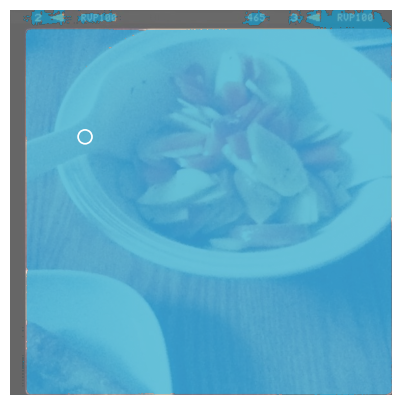

ID: 116362, PromptClass: Spoon, TargetClass: [], PredClass: ['Background', 'Spoon', 'Bowl', 'Dining Table'],
ScoreDiff: 98533.3920, MaskSizeDiff: 863.5247, IoU: 0.0000


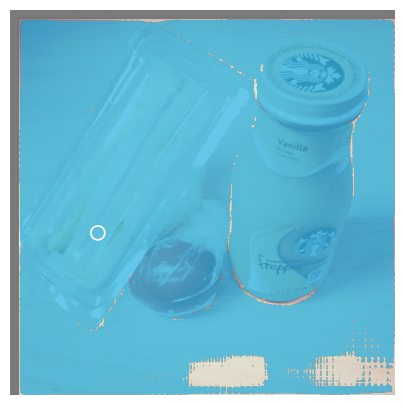

ID: 173091, PromptClass: Sandwich, TargetClass: [], PredClass: ['Bottle', 'Sandwich', 'Dining Table'],
ScoreDiff: 95850.6823, MaskSizeDiff: 862.6677, IoU: 0.0000


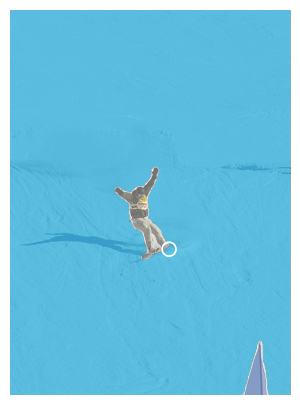

ID: 426376, PromptClass: Snowboard, TargetClass: [], PredClass: ['Background'],
ScoreDiff: 94863.4267, MaskSizeDiff: 975.2877, IoU: 0.0000


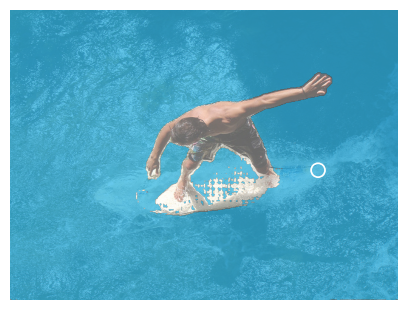

ID: 122672, PromptClass: Surfboard, TargetClass: [], PredClass: ['Background', 'Surfboard'],
ScoreDiff: 99488.7948, MaskSizeDiff: 914.5801, IoU: 0.0000


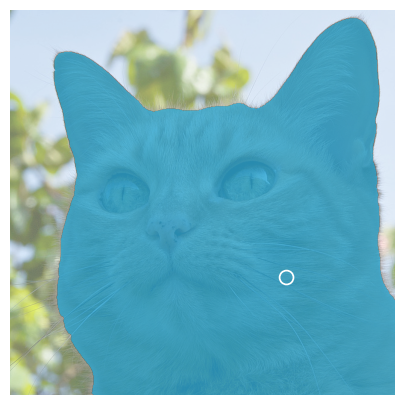

ID: 524280, PromptClass: Cat, TargetClass: [], PredClass: ['Background', 'Cat'],
ScoreDiff: 100339.6749, MaskSizeDiff: 675.2026, IoU: 0.0000


In [81]:
show_samples(min_iou, df_0, df_s, 5)

In [74]:
df_s[df_s['score']==0]

,name,prompt,class,s_class,mask,score


In [75]:
df_s

,name,prompt,class,s_class,mask,score
0,397133,"[105, 342]",67,[67],"[[False, False, False, False, False, False, Fa...",0.893054
1,37777,"[350, 209]",82,"[0, 82]","[[False, False, False, False, False, False, Fa...",0.987343
2,252219,"[90, 281]",1,[1],"[[False, False, False, False, False, False, Fa...",0.938750
3,87038,"[157, 261]",2,"[1, 2]","[[False, False, False, False, False, False, Fa...",0.758981
4,174482,"[114, 37]",10,"[0, 10]","[[False, False, False, False, False, False, Fa...",0.923577
...,...,...,...,...,...,...
3894,512403,"[364, 333]",64,[64],"[[False, False, False, False, False, False, Fa...",0.950993
3895,168974,"[226, 299]",77,"[1, 77]","[[False, False, False, False, False, False, Fa...",0.933037
3896,552775,"[73, 38]",82,[82],"[[False, False, False, False, False, False, Fa...",0.993033
3897,394940,"[115, 498]",49,[49],"[[False, False, False, False, False, False, Fa...",0.931853


# Test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch

In [ ]:
m = torch.zeros((224,224), dtype=bool)
o = torch.ones((50,50), dtype=bool)
m[100:150, :50] = o

In [ ]:
plt.imshow(m)
x, y = torch.argwhere(m==1).sum(0)/torch.sum(m)
x, y = int(x), int(y)
print(x, y)
plt.scatter(y, x, color='red')
plt.show()